In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder 
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
data = pd.read_csv('actual_sales.csv')

In [3]:
# Strip any extra spaces in the column names
data.columns = data.columns.str.strip()

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['ds'], errors='coerce', format='%d-%m-%Y')

In [4]:
# Extract time-based features
data['day_of_week'] = data['Date'].dt.day_of_week
data['month'] = data['Date'].dt.month
data['quarter'] = data['Date'].dt.quarter
data['day_of_year'] = data['Date'].dt.day_of_year
data['week_of_year'] = data['Date'].dt.isocalendar().week
data['is_weekend'] = data['day_of_week'] >= 5

# Add cyclic features for better seasonal representation
data['month_sin'] = np.sin(2 * np.pi * data['month']/12)
data['month_cos'] = np.cos(2 * np.pi * data['month']/12)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week']/7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week']/7)

In [5]:
# Encode the 'Material' column using Label Encoding
label_encoder = LabelEncoder()
data['Material'] = label_encoder.fit_transform(data['Material'])

In [6]:
# Create lag features
lags = 5
for lag in range(1, lags + 1):
    data[f'lag_{lag}'] = data['SALES QUANTITY'].shift(lag)

In [7]:
# Add rolling statistics
rolling_window = 3  # Adjust this based on your dataset's seasonality
data['rolling_mean'] = data['SALES QUANTITY'].rolling(window=rolling_window).mean()
data['rolling_std'] = data['SALES QUANTITY'].rolling(window=rolling_window).std()

In [8]:
# Add a feature for the number of days since the last sale (to capture frequency patterns)
data['days_since_last_sale'] = (data['Date'] - data['Date'].shift(1)).dt.days

# Add a seasonal flag (holiday or special events)
data['is_christmas'] = data['Date'].dt.month == 12
data['is_new_year'] = data['Date'].dt.month == 1

In [9]:
# Add seasonal flags for Indian festivals
data['is_diwali'] = data['Date'].dt.month == 11  # Diwali usually falls in October or November
data['is_holi'] = data['Date'].dt.month == 3  # Holi usually falls in March
data['is_dussehra'] = data['Date'].dt.month == 10  # Dussehra usually falls in October
data['is_independence_day'] = (data['Date'].dt.month == 8) & (data['Date'].dt.day == 15)  # Independence Day on 15th August
data['is_republic_day'] = (data['Date'].dt.month == 1) & (data['Date'].dt.day == 26)  # Republic Day on 26th January
data['is_ganesh_chaturthi'] = data['Date'].dt.month == 9  # Ganesh Chaturthi usually falls in August or September
data['is_makar_sankranti'] = (data['Date'].dt.month == 1) & (data['Date'].dt.day == 14)  # Makar Sankranti on 14th January
data['is_raksha_bandhan'] = data['Date'].dt.month == 8  # Raksha Bandhan usually falls in August
data['is_onam'] = data['Date'].dt.month == 8  # Onam usually falls in August or September
data['is_karva_chauth'] = data['Date'].dt.month == 10  # Karva Chauth usually falls in October or November

In [10]:
data.head()

,Domain Text,Business Text,Plant,Plant Text,Calendar year/month,Calendar sorted,Company Code,Product Category,Customer,Customer Group Text,...,is_diwali,is_holi,is_dussehra,is_independence_day,is_republic_day,is_ganesh_chaturthi,is_makar_sankranti,is_raksha_bandhan,is_onam,is_karva_chauth
0,LPS-Light Metal & Po,Roki Minda,P505,ROKI Minda - Bawal RMAD,202411,01-11-2024,50,NaN,50200018,MIL PSD,...,True,False,False,False,False,False,False,False,False,False
1,LPS-Light Metal & Po,Roki Minda,P500,ROKI Minda - Bawal,202411,01-11-2024,50,NaN,50100065,NaN,...,True,False,False,False,False,False,False,False,False,False
2,LPS-Light Metal & Po,Roki Minda,P500,ROKI Minda - Bawal,202411,01-11-2024,50,NaN,50100018,Others,...,True,False,False,False,False,False,False,False,False,False
3,LPS-Light Metal & Po,Roki Minda,P500,ROKI Minda - Bawal,202411,01-11-2024,50,NaN,50100001,Honda 2W,...,True,False,False,False,False,False,False,False,False,False
4,LPS-Light Metal & Po,Roki Minda,P502,ROKI Minda - Vithalapur,202411,01-11-2024,50,NaN,50100024,Suzuki PV,...,True,False,False,False,False,False,False,False,False,False


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343343 entries, 0 to 343342
Data columns (total 53 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   Domain Text                                       343343 non-null  object        
 1   Business Text                                     343343 non-null  object        
 2   Plant                                             343343 non-null  object        
 3   Plant Text                                        343343 non-null  object        
 4   Calendar year/month                               343343 non-null  int64         
 5   Calendar sorted                                   343343 non-null  object        
 6   Company Code                                      343343 non-null  int64         
 7   Product Category                                  297531 non-null  object        
 8   Customer      

In [12]:
# Define the features (X) and the target variable (y) with additional Indian festivals
X = data[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 
          'day_of_week', 'month', 'quarter', 'day_of_year', 'week_of_year', 
          'is_weekend', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
          'rolling_mean', 'rolling_std', 'days_since_last_sale', 
          'is_christmas', 'is_new_year', 'is_diwali', 'is_holi', 'is_dussehra', 
          'is_independence_day', 'is_republic_day', 'is_ganesh_chaturthi', 
          'is_makar_sankranti', 'is_raksha_bandhan', 'is_onam', 'is_karva_chauth']]

y = data['SALES QUANTITY']  # Target variable

In [13]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
# Initialize and train the Random Forest model with optimizations
rf_model = RandomForestRegressor(n_estimators=50,    # Reduce the number of estimators
                              max_depth=10,       # Limit tree depth for faster training
                              n_jobs=-1,          # Use all CPU cores for parallelism
                              random_state=42    # Set random seed for reproducibility
                            )       # Allows incremental training if necessary

In [15]:
# Initialize and train the XGBoost model with optimizations
xgb_model = XGBRegressor(n_estimators=50,    # Reduce the number of estimators
                              max_depth=10,       # Limit tree depth for faster training
                              n_jobs=-1,          # Use all CPU cores for parallelism
                              random_state=42    # Set random seed for reproducibility
                        )

In [16]:
rf_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=-1, random_state=42)

In [17]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=-1, num_parallel_tree=None, ...)

In [18]:
# Make predictions
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

In [19]:
# Evaluate performance using MSE and R-squared
models = ['Random Forest', 'XGBoost']
predictions = [rf_pred, xgb_pred]

for i in range(len(models)):
    mse = mean_squared_error(y_test, predictions[i])
    r2 = r2_score(y_test, predictions[i])
    print(f"{models[i]} - MSE: {mse:.4f}, R-squared: {r2:.4f}")

Random Forest - MSE: 32191279.7550, R-squared: 0.9646
XGBoost - MSE: 318575192.7927, R-squared: 0.6496


In [20]:
# Calculate MSE and R-squared
mse = mean_squared_error(y_test,rf_pred)
rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
r2 = r2_score(y_test,rf_pred)
mae = mean_absolute_error(y_test, rf_pred)

# Print the evaluation metrics
print("Random Forest Model Evaluation:")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

Random Forest Model Evaluation:
Mean Squared Error: 32191279.755016252
Root Mean Squared Error (RMSE): 5673.73596098869
R-squared: 0.9645911205251793
Mean Absolute Error (MAE): 1325.378310209658


In [21]:
# Get feature importances from Random Forest
feature_importances = rf_model.feature_importances_

features = X_train.columns  # X_train is your feature set
feature_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

C:\Users\EX0065\AppData\Local\Temp\ipykernel_14692\2134928484.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette='viridis')


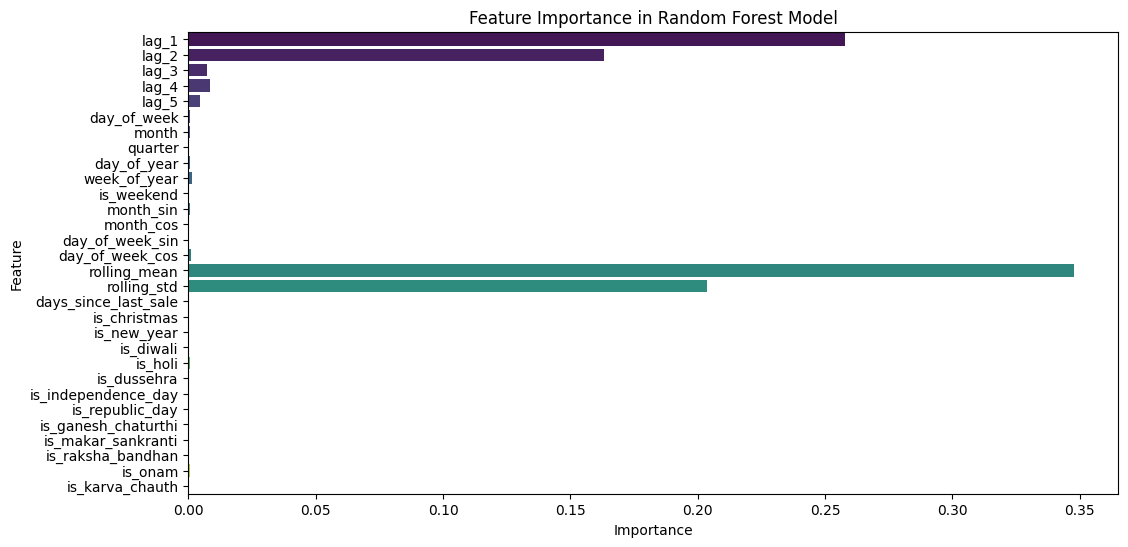

In [22]:
# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances, y=features, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.show() 

In [23]:
# Ensure data is sorted correctly
data.sort_values(by='Date', inplace=True) 

In [24]:
# Generate the correct future dates (6 months from the last date in the dataset)
last_date = data['Date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=6, freq='ME')
print(f"Forecasting for dates: {future_dates}")

# Store previous sales for dynamic lag updates
prev_sales = list(data['SALES QUANTITY'].tail(5))  # Get last 5 known sales values for lag features

Forecasting for dates: DatetimeIndex(['2024-11-30', '2024-12-31', '2025-01-31', '2025-02-28',
               '2025-03-31', '2025-04-30'],
              dtype='datetime64[ns]', freq='ME')


In [25]:
predictions = []
rf_predictions = []

# Loop through future dates and predict sales for each
for date in future_dates:
    # Create a future row with features needed for prediction
    future_row = pd.DataFrame(index=[0])
    
    # Update lag features with most recent predictions
    future_row['lag_1'] = prev_sales[-1]
    future_row['lag_2'] = prev_sales[-2]
    future_row['lag_3'] = prev_sales[-3]
    future_row['lag_4'] = prev_sales[-4]
    future_row['lag_5'] = prev_sales[-5]
    
    # Add date features
    future_row['day_of_week'] = date.dayofweek
    future_row['month'] = date.month
    future_row['quarter'] = date.quarter
    future_row['day_of_year'] = date.dayofyear
    future_row['week_of_year'] = date.isocalendar().week
    future_row['is_weekend'] = date.dayofweek >= 5
    
    # Add cyclic features for better seasonal representation
    future_row['month_sin'] = np.sin(2 * np.pi * date.month/12)
    future_row['month_cos'] = np.cos(2 * np.pi * date.month/12)
    future_row['day_of_week_sin'] = np.sin(2 * np.pi * date.dayofweek/7)
    future_row['day_of_week_cos'] = np.cos(2 * np.pi * date.dayofweek/7)
    
    # Add rolling statistics (using the most recent values)
    future_row['rolling_mean'] = np.mean(prev_sales)
    future_row['rolling_std'] = np.std(prev_sales)
    
    # Calculate days since last sale (approximate for monthly forecast)
    future_row['days_since_last_sale'] = 30  # Assume monthly interval
    
    # Add seasonal flags
    future_row['is_christmas'] = date.month == 12
    future_row['is_new_year'] = date.month == 1
    # Add seasonal flags for Indian festivals
    future_row['is_diwali'] = date.month == 11  # Diwali usually falls in October or November
    future_row['is_holi'] = date.month == 3  # Holi usually falls in March
    future_row['is_dussehra'] = date.month == 10  # Dussehra usually falls in October
    future_row['is_independence_day'] = (date.month == 8) & (date.day == 15)  # Independence Day on 15th August# Add seasonal flags for Indian festivals
    future_row['is_republic_day'] = (data['Date'].dt.month == 1) & (data['Date'].dt.day == 26)  # Republic Day on 26th January
    future_row['is_ganesh_chaturthi'] = data['Date'].dt.month == 9  # Ganesh Chaturthi usually falls in August or September
    future_row['is_makar_sankranti'] = (data['Date'].dt.month == 1) & (data['Date'].dt.day == 14)  # Makar Sankranti on 14th January
    future_row['is_raksha_bandhan'] = data['Date'].dt.month == 8  # Raksha Bandhan usually falls in August
    future_row['is_onam'] = data['Date'].dt.month == 8  # Onam usually falls in August or September
    future_row['is_karva_chauth'] = data['Date'].dt.month == 10  # Karva Chauth usually falls in October or November
    
    # Predict sales using Random Forest model
    rf_prediction = rf_model.predict(future_row)[0]
    rf_predictions.append(rf_prediction)
    
    
    # Update previous sales list for the next iteration
    prev_sales.append(rf_prediction)
    prev_sales.pop(0)  # Remove oldest value to maintain 5 values

In [26]:
# Create a DataFrame with forecasted sales
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'RF_Predicted_Sales': rf_predictions
})

In [27]:
# Print the forecasted sales using Random Forest
print("\nSales Forecast for Next 6 Months:")
print(forecast_df)


Sales Forecast for Next 6 Months:
        Date  RF_Predicted_Sales
0 2024-11-30         6852.539241
1 2024-12-31         4462.561049
2 2025-01-31         1882.631039
3 2025-02-28         1821.353911
4 2025-03-31         3849.969878
5 2025-04-30         7917.072643


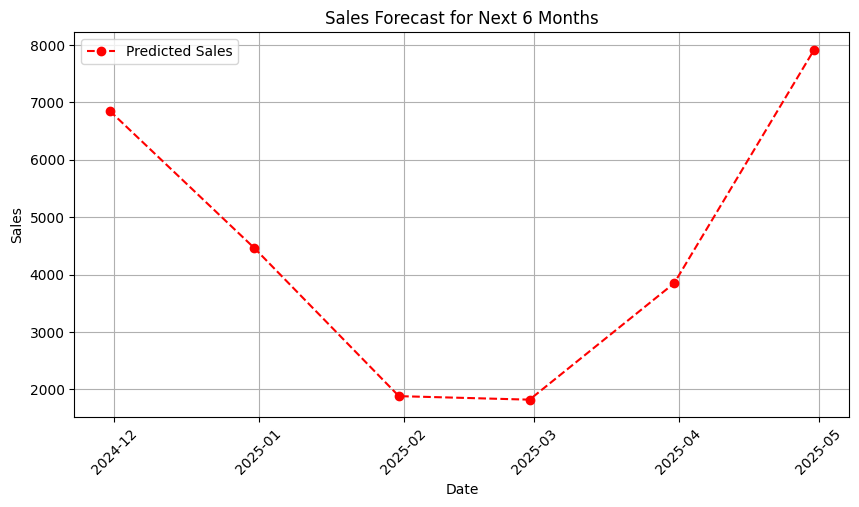

In [28]:
plt.figure(figsize=(10, 5))
# Plot using the forecast_df DataFrame which contains the correct data
plt.plot(forecast_df['Date'], forecast_df['RF_Predicted_Sales'], marker='o', linestyle='dashed', color='red', label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast for Next 6 Months')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()